In [ ]:
pip install pydot graphviz

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached pydot-2.0.0-py3-none-any.whl (22 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
dbutils.library.restartPython()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
emails_df = pd.read_csv('/dbfs/nishadi/top_100_senders_output.csv')
emails_df.rename(columns={'from_': 'from'}, inplace=True)
emails_df = emails_df.dropna()

# Encode the labels
label_encoder = LabelEncoder()
emails_df['label_encoded'] = label_encoder.fit_transform(emails_df['from'])

# Split the data into train, test, and validation sets
train_df, remaining_df = train_test_split(emails_df, test_size=0.3, stratify=emails_df['label_encoded'], random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['label_encoded'], random_state=42)

Y_train = train_df['label_encoded'].values
Y_test = test_df['label_encoded'].values
Y_val = val_df['label_encoded'].values

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = dict(enumerate(class_weights))

# Tokenizer and tokenization
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
max_len = 100

def tokenize_data(df):
    return tokenizer(
        text=df.body.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

x_train = tokenize_data(train_df)
x_test = tokenize_data(test_df)
x_val = tokenize_data(val_df)

2024-06-01 05:04:25.676133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Load BERT model for sequence classification
bert_model = TFBertModel.from_pretrained('bert-base-cased')

# Custom model with dropout layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

embeddings = bert_model(input_ids, attention_mask=attention_mask)[0]
x = GlobalAveragePooling1D()(embeddings)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(100, activation=None)(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                       

In [ ]:
from tensorflow.keras.utils import plot_model

# Save the model architecture as a PNG file
plot_model(model, to_file='/dbfs/nishadi/model_architecture.png', show_shapes=True, show_layer_names=True)

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa32d119-1bd4-424d-aa91-0c44044999bf/lib/python3.10/site-packages/pydot/core.py:1753, in Dot.create(self, prog, format, encoding)
   1752 try:
-> 1753     stdout_data, stderr_data, process = call_graphviz(
   1754         program=prog,
   1755         arguments=arguments,
   1756         working_dir=tmp_dir,
   1757     )
   1758 except OSError as e:

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa32d119-1bd4-424d-aa91-0c44044999bf/lib/python3.10/site-packages/pydot/core.py:133, in call_graphviz(program, arguments, working_dir, **kwargs)
    131 program_with_args = [program] + arguments
--> 133 process = subprocess.Popen(
    134     program_with_args,
    135     env=env,
    136     cwd=working_dir,
    137     shell=False,
    138     stderr=subprocess.PIPE,
    139     stdout=subpro

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    [x_train['input_ids'], x_train['attention_mask']],
    Y_train,
    validation_data=(
        [x_val['input_ids'], x_val['attention_mask']],
        Y_val
    ),
    epochs=6,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/6
137/287 [=============>................] - ETA: 15:24 - loss: 4.6243 - accuracy: 0.0144

*** WARNING: max output size exceeded, skipping output. ***

287/287 [==============================] - 1879s 7s/step - loss: 1.6455 - accuracy: 0.5803 - val_loss: 1.7812 - val_accuracy: 0.5863
INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-5de17-e8724-f2f32-5/tmpathxaobx/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-5de17-e8724-f2f32-5/tmpathxaobx/model/data/model/assets


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-5de17-e8724-f2f32-5/tmpathxaobx/model/data/model/variables/variabl…

Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Evaluate the model on the training data
train_results = model.evaluate([x_train['input_ids'], x_train['attention_mask']], Y_train)
print(f'Train Results: {train_results}')

# Evaluate the model on the validation data
val_results = model.evaluate([x_val['input_ids'], x_val['attention_mask']], Y_val)
print(f'Validation Results: {val_results}')

# Evaluate the model on the test data
test_results = model.evaluate([x_test['input_ids'], x_test['attention_mask']], Y_test)
print(f'Test Results: {test_results}')

145/287 [==============>...............] - ETA: 4:04 - loss: 1.2455 - accuracy: 0.71

*** WARNING: max output size exceeded, skipping output. ***

287/287 [==============================] - 497s 2s/step - loss: 1.2335 - accuracy: 0.7160
Train Results: [1.2335151433944702, 0.7160480618476868]
62/62 [==============================] - 105s 2s/step - loss: 1.7812 - accuracy: 0.5863
Validation Results: [1.7811822891235352, 0.5863474011421204]
62/62 [==============================] - 105s 2s/step - loss: 1.7428 - accuracy: 0.5911
Test Results: [1.7427990436553955, 0.5911405086517334]


62/62 [==============================] - 104s 2s/step
Test Accuracy: 0.5911405295315683
Test F1 Score: 0.5932574053495394
                                                           precision    recall  f1-score   support

"Kenneth G Gruhl" <kggruhl@duke-energy.com>@ENRON [mailto       0.88      0.88      0.88         8
                                             Arnold, John       0.75      0.40      0.52        15
                                               Bass, Eric       0.30      0.33      0.32         9
                                              Blair, Lynn       0.56      0.90      0.69        10
                                           Buckley, Karen       1.00      0.85      0.92        13
                                          Corman, Shelley       0.15      0.33      0.21         9
                                           Dasovich, Jeff       0.62      0.34      0.44        29
                                            Donoho, Lindy       0.54      0.88      0

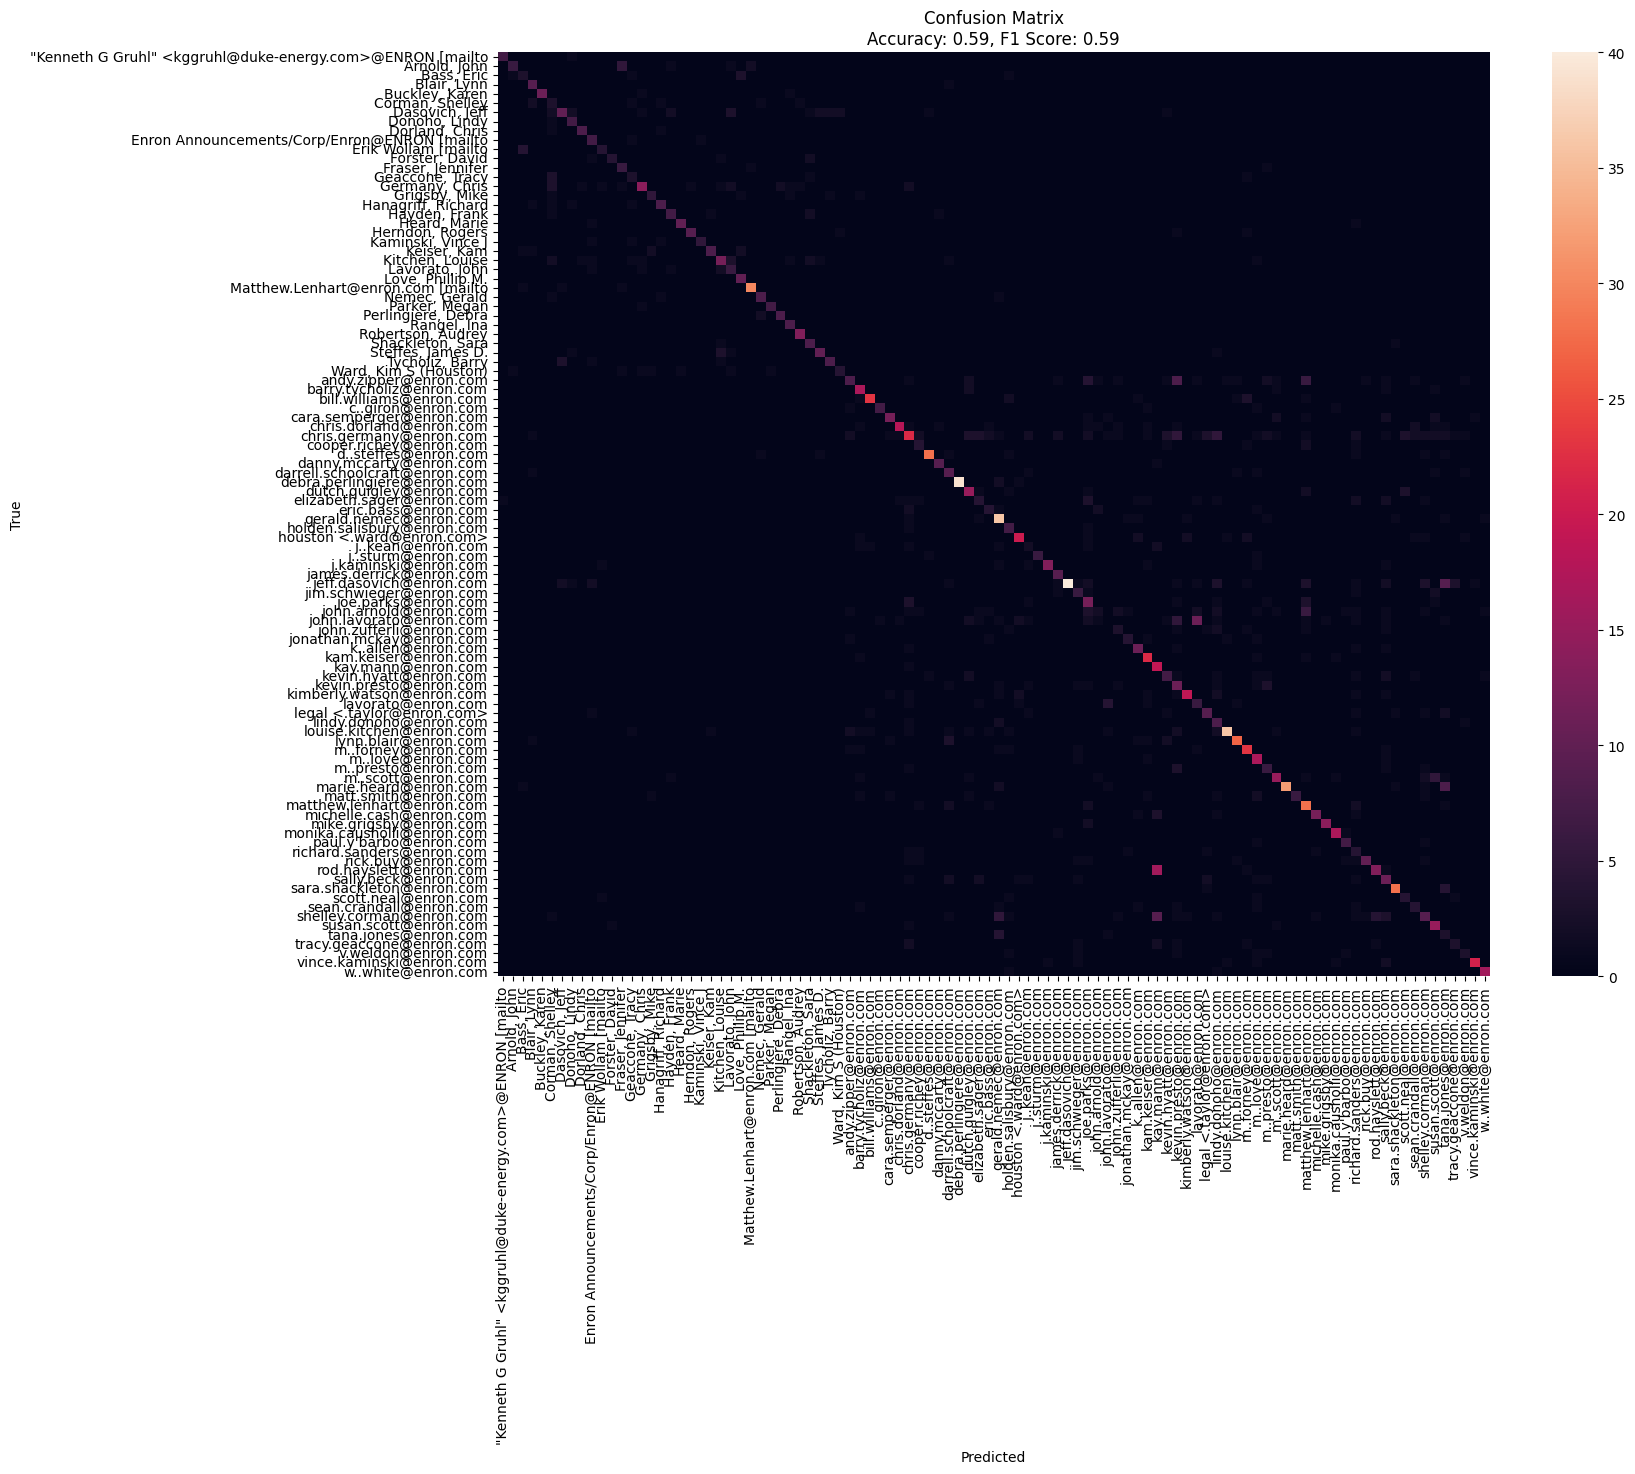

In [ ]:
# Predictions on the test set
predictions = model.predict([x_test['input_ids'], x_test['attention_mask']])
y_pred = np.argmax(predictions, axis=1)

# Calculate metrics for the test set
test_accuracy = accuracy_score(Y_test, y_pred)
test_f1 = f1_score(Y_test, y_pred, average='weighted')

print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(classification_report(Y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix for test set
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nAccuracy: {test_accuracy:.2f}, F1 Score: {test_f1:.2f}')
plt.show()

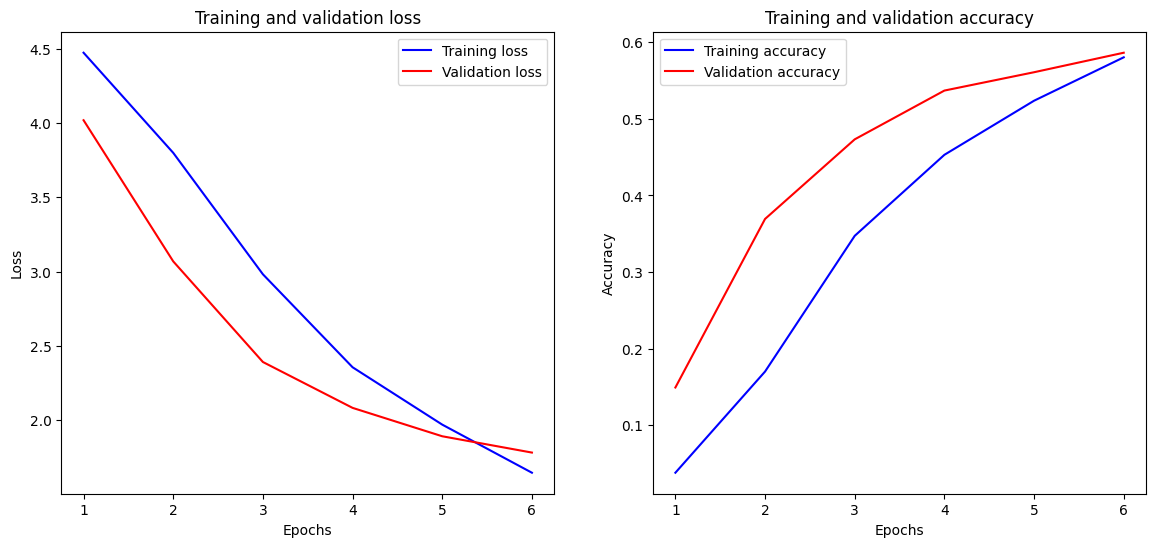

In [ ]:
# Plot training & validation loss and accuracy values
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(epochs, train_loss, 'b', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, train_accuracy, 'b', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()